In [1]:
# To add a new cell, type '# %%'
# To add a new markdown cell, type '# %% [markdown]'
# %% [markdown]
# # Feature Engineering, Baseline Model and Feature Selection


 ## Import necessary dependencies

In [2]:
import pandas
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import numpy
from sklearn.feature_selection import chi2
from PIL import Image
from collections import Counter
import re
import sqlite3
from sklearn import decomposition, ensemble
import nltk
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence
import pydot
import seaborn as sns
from sklearn.metrics import precision_recall_curve # The average precision score in multi-label settings
from sklearn.metrics import average_precision_score
from sklearn import svm # Support Vector Machine
from sklearn.preprocessing import label_binarize # Split category encoding eg. y=[1,2,3] into y1=[0,1], y2=[0,1], y3=[0,1]
from sklearn.model_selection import train_test_split # Built-in train test splitter
from sklearn.multiclass import OneVsRestClassifier # We use OneVsRestClassifier for multi-label prediction
from itertools import cycle
from sklearn.feature_selection import SelectPercentile, f_classif


Using TensorFlow backend.


 ## Load in the data from the database

In [3]:
dbconn = sqlite3.connect('./data/cleanedtraintest_v2.db')
train_data_df = pandas.read_sql_query('SELECT * FROM train_data', dbconn)
test_data_df = pandas.read_sql_query('SELECT * FROM test_data', dbconn)
dbconn.commit()
dbconn.close()


 ### Check the if the data was loaded correctly

In [4]:
train_data_df.head()


index  category                                           headline  \
0      0         3  Wall St. Bears Claw Back Into the Black (Reuters)   
1      1         3  Carlyle Looks Toward Commercial Aerospace (Reu...   
2      2         3    Oil and Economy Cloud Stocks' Outlook (Reuters)   
3      3         3  Iraq Halts Oil Exports from Main Southern Pipe...   
4      4         3  Oil prices soar to all-time record, posing new...   

                                             content  \
0  Reuters - Short-sellers, Wall Street's dwindli...   
1  Reuters - Private investment firm Carlyle Grou...   
2  Reuters - Soaring crude prices plus worries\ab...   
3  Reuters - Authorities have halted oil export\f...   
4  AFP - Tearaway world oil prices, toppling reco...   

                                    headline_cleaned  \
0                         wall bears claw back black   
1          carlyle looks toward commercial aerospace   
2                   oil economy cloud stocks outlook   
3      iraq halts oil exports main southern pipeline   
4  oil prices soar record posing new menace us ec...   

                                     content_cleaned  \
0                           wall street seeing green   
1  private investment firm carlyle group reputati...   
2  soaring crude prices plus economy outlook earn...   
3  authorities halted oil main pipeline southern ...   
4  tearaway world oil prices toppling records str...   

                                   content_nosources  
0    Short-sellers, Wall Street's dwindling\band ...  
1    Private investment firm Carlyle Group,\which...  
2    Soaring crude prices plus worries\about the ...  
3    Authorities have halted oil export\flows fro...  
4    Tearaway world oil prices, toppling records ...

In [5]:
train_data_df.drop('index', axis=1, inplace=True)
train_data_df.head()


category                                           headline  \
0         3  Wall St. Bears Claw Back Into the Black (Reuters)   
1         3  Carlyle Looks Toward Commercial Aerospace (Reu...   
2         3    Oil and Economy Cloud Stocks' Outlook (Reuters)   
3         3  Iraq Halts Oil Exports from Main Southern Pipe...   
4         3  Oil prices soar to all-time record, posing new...   

                                             content  \
0  Reuters - Short-sellers, Wall Street's dwindli...   
1  Reuters - Private investment firm Carlyle Grou...   
2  Reuters - Soaring crude prices plus worries\ab...   
3  Reuters - Authorities have halted oil export\f...   
4  AFP - Tearaway world oil prices, toppling reco...   

                                    headline_cleaned  \
0                         wall bears claw back black   
1          carlyle looks toward commercial aerospace   
2                   oil economy cloud stocks outlook   
3      iraq halts oil exports main southern pipeline   
4  oil prices soar record posing new menace us ec...   

                                     content_cleaned  \
0                           wall street seeing green   
1  private investment firm carlyle group reputati...   
2  soaring crude prices plus economy outlook earn...   
3  authorities halted oil main pipeline southern ...   
4  tearaway world oil prices toppling records str...   

                                   content_nosources  
0    Short-sellers, Wall Street's dwindling\band ...  
1    Private investment firm Carlyle Group,\which...  
2    Soaring crude prices plus worries\about the ...  
3    Authorities have halted oil export\flows fro...  
4    Tearaway world oil prices, toppling records ...

In [6]:
test_data_df.head()


index  category                                           headline  \
0      0         3                  Fears for T N pension after talks   
1      1         4  The Race is On: Second Private Team Sets Launc...   
2      2         4      Ky. Company Wins Grant to Study Peptides (AP)   
3      3         4      Prediction Unit Helps Forecast Wildfires (AP)   
4      4         4        Calif. Aims to Limit Farm-Related Smog (AP)   

                                             content  \
0  Unions representing workers at Turner   Newall...   
1  SPACE.com - TORONTO, Canada -- A second\team o...   
2  AP - A company founded by a chemistry research...   
3  AP - It's barely dawn when Mike Fitzpatrick st...   
4  AP - Southern California's smog-fighting agenc...   

                                    headline_cleaned  \
0                              fears n pension talks   
1  race second private team sets launch date huma...   
2                  company wins grant study peptides   
3           prediction unit helps forecast wildfires   
4                              calif aims limit smog   

                                     content_cleaned  \
0  unions representing workers turner newall say ...   
1  toronto canada rocketeers competing million an...   
2  company founded chemistry researcher universit...   
3  barely dawn mike fitzpatrick starts shift blur...   
4  southern california agency went emissions bovi...   

                                   content_nosources  
0  Unions representing workers at Turner   Newall...  
1    TORONTO, Canada -- A second\team of rocketee...  
2    A company founded by a chemistry researcher ...  
3    It's barely dawn when Mike Fitzpatrick start...  
4    Southern California's smog-fighting agency w...

In [7]:
test_data_df.drop('index', axis=1, inplace=True)
test_data_df.head()


category                                           headline  \
0         3                  Fears for T N pension after talks   
1         4  The Race is On: Second Private Team Sets Launc...   
2         4      Ky. Company Wins Grant to Study Peptides (AP)   
3         4      Prediction Unit Helps Forecast Wildfires (AP)   
4         4        Calif. Aims to Limit Farm-Related Smog (AP)   

                                             content  \
0  Unions representing workers at Turner   Newall...   
1  SPACE.com - TORONTO, Canada -- A second\team o...   
2  AP - A company founded by a chemistry research...   
3  AP - It's barely dawn when Mike Fitzpatrick st...   
4  AP - Southern California's smog-fighting agenc...   

                                    headline_cleaned  \
0                              fears n pension talks   
1  race second private team sets launch date huma...   
2                  company wins grant study peptides   
3           prediction unit helps forecast wildfires   
4                              calif aims limit smog   

                                     content_cleaned  \
0  unions representing workers turner newall say ...   
1  toronto canada rocketeers competing million an...   
2  company founded chemistry researcher universit...   
3  barely dawn mike fitzpatrick starts shift blur...   
4  southern california agency went emissions bovi...   

                                   content_nosources  
0  Unions representing workers at Turner   Newall...  
1    TORONTO, Canada -- A second\team of rocketee...  
2    A company founded by a chemistry researcher ...  
3    It's barely dawn when Mike Fitzpatrick start...  
4    Southern California's smog-fighting agency w...

 ### Sample 4000 rows

In [8]:
train_data_sample = train_data_df.sample(n = 4000, replace = False, random_state = 123)
train_data_sample.head()


category                                         headline  \
30870         2  NHL on Ice, Maybe for Whole 2004-05 Season (AP)   
7738          2  Rowers to be punished for criticism of teammate   
25351         2                              Changing Directions   
74309         4               Cassini snapshots murky moon Titan   
88347         1                           Farewell Yasser Arafat   

                                                 content  \
30870  AP - No shots, no saves, no goals. The Nationa...   
7738   ROWER Sally Robbins #39;s teammates are expect...   
25351  Over at USA Today -- Slogan: "All the News Tha...   
74309  The Cassini probe got the first close-up photo...   
88347  GAZA CITY, 12 November 2004 - The world will b...   

                         headline_cleaned  \
30870          nhl ice maybe whole season   
7738   rowers punished criticism teammate   
25351                 changing directions   
74309  cassini snapshots murky moon titan   
88347              farewell yasser arafat   

                                         content_cleaned  \
30870  shots saves goals national hockey league locke...   
7738   rower sally robbins teammates expected face di...   
25351  slogan news fit print four paragraphs less got...   
74309  cassini probe got first photos saturn murky mo...   
88347  gaza city world bid farewell abu ammar yasser ...   

                                       content_nosources  
30870    No shots, no saves, no goals. The National H...  
7738   ROWER Sally Robbins #39;s teammates are expect...  
25351  Over at  - Slogan: "All the News That's Fit to...  
74309  The Cassini probe got the first close-up photo...  
88347  GAZA CITY, - The world will bid farewell to Ab...

In [9]:
test_data_sample = test_data_df.sample(n = 4000, replace = False, random_state = 123)
test_data_sample.head()


category                                           headline  \
646          1                   Panama pardons Castro 'plotters'   
2616         4      Elephant DNA Could Help Stem Ivory Trade (AP)   
2300         1        Job-Loss Panic Rises in Western Europe (AP)   
4764         1  Remark on Homosexuality Delays Seating of Euro...   
3617         3    Linux: Paris weighs a shift to open-source camp   

                                                content  \
646   Four men accused of planning to kill Cuba's Fi...   
2616  AP - Analyzing the DNA of elephants may help t...   
2300  AP - Stephane Zervos first suspected his job w...   
4764  The European Union #39;s normally yawn-inducin...   
3617  PARIS The open-source computer system known as...   

                                       headline_cleaned  \
646                               panama pardons castro   
2616           elephant dna could help stem ivory trade   
2300                         panic rises western europe   
4764  remark homosexuality delays seating european p...   
3617                      linux paris weighs shift camp   

                                        content_cleaned  \
646   four men accused planning kill cuba fidel cast...   
2616  analyzing dna elephants may help trace origins...   
2300  stephane zervos first suspected job threatened...   
4764  european union normally institutions raised ey...   
3617  paris computer system known linux tough battle...   

                                      content_nosources  
646   Four men accused of planning to kill Cuba's Fi...  
2616    Analyzing the DNA of elephants may help trac...  
2300    Stephane Zervos first suspected his job was ...  
4764  The European Union #39;s normally yawn-inducin...  
3617  PARIS The open-source computer system known as...

 ## Train & Test data where x is the predictor features, y is the predicted feature

In [10]:
n_classes = 4

x_train = train_data_sample.content_cleaned
y_train = label_binarize(train_data_sample.category, classes=[1, 2, 3, 4])

x_test = test_data_sample.content_cleaned
y_test = label_binarize(test_data_sample.category, classes=[1, 2, 3, 4])


 ### Let's make a Bag of Words

In [11]:
# Use countvectorizer to get a vector of words
cv = CountVectorizer(min_df = 2, lowercase = True,
                     token_pattern=r'\b[A-Za-z]{2,}\b', ngram_range = (1, 1))
x_train_cv = cv.fit_transform(x_train)
x_test_cv = cv.transform(x_test)

selector = SelectPercentile(f_classif, percentile=10)
selector.fit(x_train_cv, train_data_sample.category)
x_train_cv_10p = selector.transform(x_train_cv).toarray()
x_test_cv_10p = selector.transform(x_test_cv).toarray()

# get all unique words in the corpus
bow_vocab = cv.get_feature_names()

columns = numpy.asarray(bow_vocab)
support = numpy.asarray(selector.get_support())
bow_vocab_10p = columns[support]

x_train_cv = x_train_cv.toarray()
x_test_cv = x_test_cv.toarray()

# produce a dataframe including the feature names
x_train_bagofwords = pandas.DataFrame(x_train_cv, columns=bow_vocab)
x_test_bagofwords = pandas.DataFrame(x_test_cv, columns=bow_vocab)
x_train_bagofwords_10p = pandas.DataFrame(x_train_cv_10p, columns=bow_vocab_10p)
x_test_bagofwords_10p = pandas.DataFrame(x_test_cv_10p, columns=bow_vocab_10p)
x_train_bagofwords.head()


aaron  ab  abandon  abandoned  abandons  abbas  abc  abducted  abduction  \
0      0   0        0          0         0      0    0         0          0   
1      0   0        0          0         0      0    0         0          0   
2      0   0        0          0         0      0    0         0          0   
3      0   0        0          0         0      0    0         0          0   
4      0   0        0          0         0      0    0         0          0   

   abductions  ...  zaragoza  zdnet  zealand  zee  zero  zimbabwe  zone  zook  \
0           0  ...         0      0        0    0     0         0     0     0   
1           0  ...         0      0        0    0     0         0     0     0   
2           0  ...         0      0        0    0     0         0     0     0   
3           0  ...         0      0        0    0     0         0     0     0   
4           0  ...         0      0        0    0     0         0     0     0   

   zurich  zvonareva  
0       0          0  
1       0          0  
2       0          0  
3       0          0  
4       0          0  

[5 rows x 6873 columns]

In [12]:
x_test_bagofwords_10p.head()


abducted  abu  access  according  accounting  accused  administration  \
0         0    0       0          0           0        1               0   
1         0    0       0          0           0        0               0   
2         0    0       0          0           0        0               0   
3         0    0       0          0           0        0               0   
4         0    0       0          0           0        0               0   

   adrian  afghan  afghanistan  ...  writes  xp  yahoo  yankees  yards  \
0       0       0            0  ...       0   0      0        0      0   
1       0       0            0  ...       0   0      0        0      0   
2       0       0            0  ...       0   0      0        0      0   
3       0       0            0  ...       0   0      0        0      0   
4       0       0            0  ...       0   0      0        0      0   

   yasser  yen  yesterday  york  yukos  
0       0    0          0     0      0  
1       0    0          0     0      0  
2       0    0          0     0      0  
3       0    0          0     0      0  
4       0    0          0     0      0  

[5 rows x 687 columns]

 ### We have bag of words already, let's make a Bag of N-Grams

In [13]:
# Use countvectorizer to get a vector of ngrams
cv = CountVectorizer(min_df = 2, lowercase = True,
                     token_pattern=r'\b[A-Za-z]{2,}\b', ngram_range = (2, 3))
x_train_cv = cv.fit_transform(x_train)
x_test_cv = cv.transform(x_test)

# get all unique words in the corpus
ngram_vocab = cv.get_feature_names()

selector = SelectPercentile(f_classif, percentile=10)
selector.fit(x_train_cv, train_data_sample.category)
x_train_cv_10p = selector.transform(x_train_cv).toarray()
x_test_cv_10p = selector.transform(x_test_cv).toarray()

columns = numpy.asarray(ngram_vocab)
support = numpy.asarray(selector.get_support())
ngram_vocab_10p = columns[support]

x_train_cv = x_train_cv.toarray()
x_test_cv = x_test_cv.toarray()

# produce a dataframe including the feature names
x_train_bagofngrams = pandas.DataFrame(x_train_cv, columns=ngram_vocab)
x_test_bagofngrams = pandas.DataFrame(x_test_cv, columns=ngram_vocab)
x_train_bagofngrams_10p = pandas.DataFrame(x_train_cv_10p, columns=ngram_vocab_10p)
x_test_bagofngrams_10p = pandas.DataFrame(x_test_cv_10p, columns=ngram_vocab_10p)
x_train_bagofngrams.head()


ab billion  abducted militants  abductions foreigners  \
0           0                   0                      0   
1           0                   0                      0   
2           0                   0                      0   
3           0                   0                      0   
4           0                   0                      0   

   abductions foreigners iraq  aboard international  \
0                           0                     0   
1                           0                     0   
2                           0                     0   
3                           0                     0   
4                           0                     0   

   aboard international space  abu ghraib  abu ghraib prison  abu musab  \
0                           0           0                  0          0   
1                           0           0                  0          0   
2                           0           0                  0          0   
3                           0           0                  0          0   
4                           0           0                  0          0   

   ac milan  ...  yukos said  yukos said would  zdnet survey  \
0         0  ...           0                 0             0   
1         0  ...           0                 0             0   
2         0  ...           0                 0             0   
3         0  ...           0                 0             0   
4         0  ...           0                 0             0   

   zdnet survey professionals  zealand biggest  zee tv  zimbabwe ruling  \
0                           0                0       0                0   
1                           0                0       0                0   
2                           0                0       0                0   
3                           0                0       0                0   
4                           0                0       0                0   

   zimbabwe ruling party  zone central  zone central baghdad  
0                      0             0                     0  
1                      0             0                     0  
2                      0             0                     0  
3                      0             0                     0  
4                      0             0                     0  

[5 rows x 5929 columns]

In [14]:
# Use countvectorizer to get a vector of chars
cv = CountVectorizer(analyzer='char', min_df = 2, ngram_range = (2, 3), 
                     token_pattern=r'\b[A-Za-z]{2,}\b')
x_train_cv = cv.fit_transform(x_train)
x_test_cv = cv.transform(x_test)

# get all unique words in the corpus
cv_char_vocab = cv.get_feature_names()

selector = SelectPercentile(f_classif, percentile=10)
selector.fit(x_train_cv, train_data_sample.category)
x_train_cv_10p = selector.transform(x_train_cv).toarray()
x_test_cv_10p = selector.transform(x_test_cv).toarray()

columns = numpy.asarray(cv_char_vocab)
support = numpy.asarray(selector.get_support())
cv_char_vocab_10p = columns[support]

x_train_cv = x_train_cv.toarray()
x_test_cv = x_test_cv.toarray()

# produce a dataframe including the feature names
x_train_cv_char = pandas.DataFrame(x_train_cv, columns = cv_char_vocab)
x_test_cv_char = pandas.DataFrame(x_test_cv, columns=cv_char_vocab)
x_train_cv_char_10p = pandas.DataFrame(x_train_cv_10p, columns = cv_char_vocab_10p)
x_test_cv_char_10p = pandas.DataFrame(x_test_cv_10p, columns=cv_char_vocab_10p)
x_train_cv_char.head()


a   aa   ab   ac   ad   ae   af   ag   ah   ai  ...  zur  zv  zvo  zy  \
0   0    0    0    0    0    0    0    0    0    0  ...    0   0    0   0   
1   1    0    0    1    0    0    0    0    0    0  ...    0   0    0   0   
2   1    0    0    0    0    0    0    0    0    0  ...    0   0    0   0   
3   0    0    0    0    0    0    0    0    0    0  ...    0   0    0   1   
4   4    0    1    0    0    0    0    0    0    0  ...    0   0    0   0   

   zy   zz  zz   zza  zzi  zzl  
0    0   0    0    0    0    0  
1    0   0    0    0    0    0  
2    0   0    0    0    0    0  
3    1   0    0    0    0    0  
4    0   0    0    0    0    0  

[5 rows x 5834 columns]

 ### Let's explore the data we got through plots and tables

In [15]:
def words_barchart(df, df_label):
    word_count_dict = {}
    for word in df_label:
        word_count_dict[word] = int(sum(df.loc[:, word]))

    counter = Counter(word_count_dict)

    freq_df = pandas.DataFrame.from_records(counter.most_common(40),
                                            columns=['Top 40 words', 'Frequency'])

    plt.figure(figsize=(10,5))
    chart = sns.barplot(
        data=freq_df,
        x='Top 40 words',
        y='Frequency'
    )

    chart.set_xticklabels(
        chart.get_xticklabels(), 
        rotation=45, 
        horizontalalignment='right',
        fontweight='light'
    )


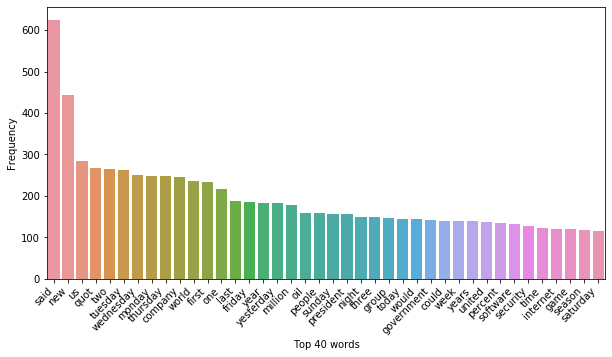

In [16]:
words_barchart(x_train_bagofwords, bow_vocab)


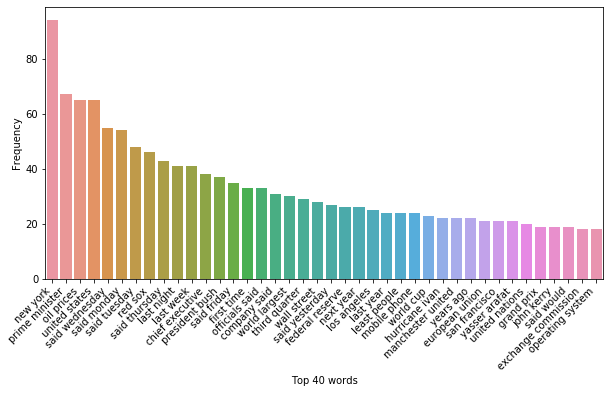

In [17]:
words_barchart(x_train_bagofngrams, ngram_vocab)


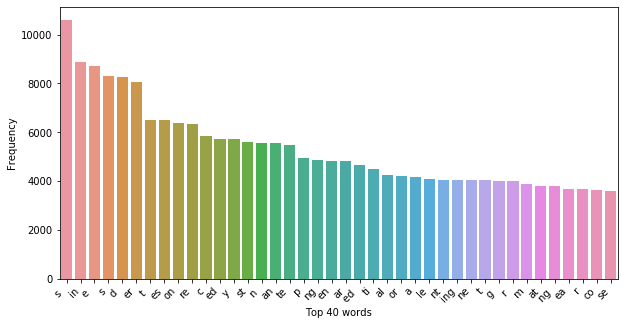

In [18]:
words_barchart(x_train_cv_char, cv_char_vocab)


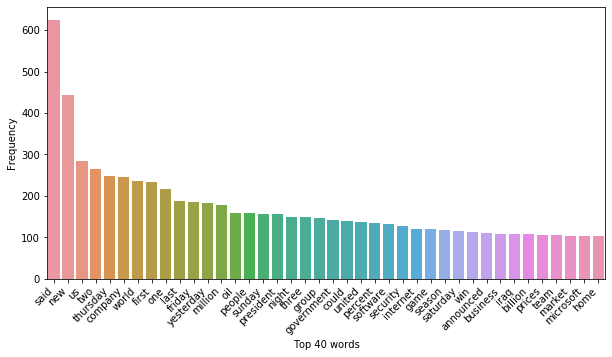

In [19]:
words_barchart(x_train_bagofwords_10p, bow_vocab_10p)


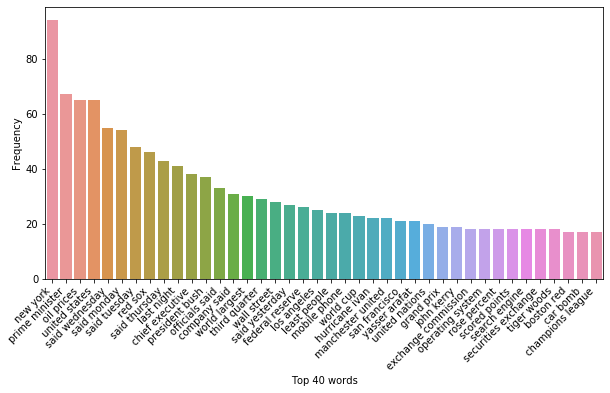

In [20]:
words_barchart(x_train_bagofngrams_10p, ngram_vocab_10p)


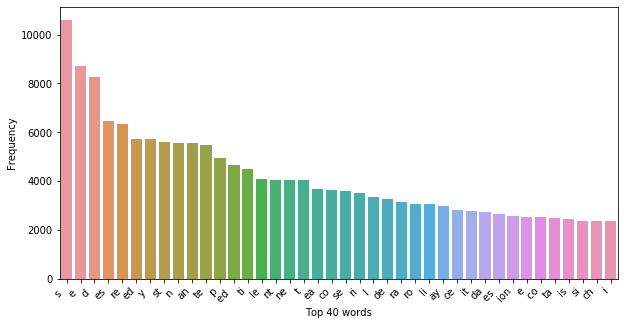

In [21]:
words_barchart(x_train_cv_char_10p, cv_char_vocab_10p)


 ## TF/IDF

 ### Unigram TF/IDF

In [22]:

# Use TF/IDF vectorizer to get a vector of unigrams
tfidf_vect = TfidfVectorizer(sublinear_tf = True, min_df = 2, ngram_range = (1, 1), 
                             use_idf = True, token_pattern=r'\b[A-Za-z]{2,}\b')
x_train_tfidf_unigram = tfidf_vect.fit_transform(x_train).toarray()
x_test_tfidf_unigram = tfidf_vect.transform(x_test).toarray()

# get all unique words in the corpus
vocab = tfidf_vect.get_feature_names()

# produce a dataframe including the feature names
x_train_tfidf_unigram = pandas.DataFrame(numpy.round(x_train_tfidf_unigram, 2), columns = vocab)
x_test_tfidf_unigram = pandas.DataFrame(numpy.round(x_test_tfidf_unigram, 2), columns = vocab)
x_train_tfidf_unigram.head()


aaron   ab  abandon  abandoned  abandons  abbas  abc  abducted  abduction  \
0    0.0  0.0      0.0        0.0       0.0    0.0  0.0       0.0        0.0   
1    0.0  0.0      0.0        0.0       0.0    0.0  0.0       0.0        0.0   
2    0.0  0.0      0.0        0.0       0.0    0.0  0.0       0.0        0.0   
3    0.0  0.0      0.0        0.0       0.0    0.0  0.0       0.0        0.0   
4    0.0  0.0      0.0        0.0       0.0    0.0  0.0       0.0        0.0   

   abductions  ...  zaragoza  zdnet  zealand  zee  zero  zimbabwe  zone  zook  \
0         0.0  ...       0.0    0.0      0.0  0.0   0.0       0.0   0.0   0.0   
1         0.0  ...       0.0    0.0      0.0  0.0   0.0       0.0   0.0   0.0   
2         0.0  ...       0.0    0.0      0.0  0.0   0.0       0.0   0.0   0.0   
3         0.0  ...       0.0    0.0      0.0  0.0   0.0       0.0   0.0   0.0   
4         0.0  ...       0.0    0.0      0.0  0.0   0.0       0.0   0.0   0.0   

   zurich  zvonareva  
0     0.0        0.0  
1     0.0        0.0  
2     0.0        0.0  
3     0.0        0.0  
4     0.0        0.0  

[5 rows x 6873 columns]

 ### N-Gram TF/IDF
 Use TF/IDF vectorizer to get a vector of n-grams

In [23]:
tfidf_vect = TfidfVectorizer(sublinear_tf = True, min_df = 2, ngram_range = (2, 3), 
                             use_idf = True, token_pattern=r'\b[A-Za-z]{2,}\b')
x_train_tfidf_ngram = tfidf_vect.fit_transform(x_train).toarray()
x_test_tfidf_ngram = tfidf_vect.transform(x_test).toarray()
# get all unique words in the corpus
vocab = tfidf_vect.get_feature_names()

# produce a dataframe including the feature names
x_train_tfidf_ngram = pandas.DataFrame(numpy.round(x_train_tfidf_ngram, 2), columns = vocab)
x_test_tfidf_ngram = pandas.DataFrame(numpy.round(x_test_tfidf_ngram, 2), columns = vocab)
x_train_tfidf_ngram.head()


ab billion  abducted militants  abductions foreigners  \
0         0.0                 0.0                    0.0   
1         0.0                 0.0                    0.0   
2         0.0                 0.0                    0.0   
3         0.0                 0.0                    0.0   
4         0.0                 0.0                    0.0   

   abductions foreigners iraq  aboard international  \
0                         0.0                   0.0   
1                         0.0                   0.0   
2                         0.0                   0.0   
3                         0.0                   0.0   
4                         0.0                   0.0   

   aboard international space  abu ghraib  abu ghraib prison  abu musab  \
0                         0.0         0.0                0.0        0.0   
1                         0.0         0.0                0.0        0.0   
2                         0.0         0.0                0.0        0.0   
3                         0.0         0.0                0.0        0.0   
4                         0.0         0.0                0.0        0.0   

   ac milan  ...  yukos said  yukos said would  zdnet survey  \
0       0.0  ...         0.0               0.0           0.0   
1       0.0  ...         0.0               0.0           0.0   
2       0.0  ...         0.0               0.0           0.0   
3       0.0  ...         0.0               0.0           0.0   
4       0.0  ...         0.0               0.0           0.0   

   zdnet survey professionals  zealand biggest  zee tv  zimbabwe ruling  \
0                         0.0              0.0     0.0              0.0   
1                         0.0              0.0     0.0              0.0   
2                         0.0              0.0     0.0              0.0   
3                         0.0              0.0     0.0              0.0   
4                         0.0              0.0     0.0              0.0   

   zimbabwe ruling party  zone central  zone central baghdad  
0                    0.0           0.0                   0.0  
1                    0.0           0.0                   0.0  
2                    0.0           0.0                   0.0  
3                    0.0           0.0                   0.0  
4                    0.0           0.0                   0.0  

[5 rows x 5929 columns]

 ### Character TF/IDF
 Use TF/IDF vectorizer to get a vector of chars

In [24]:
tfidf_vect = TfidfVectorizer(analyzer = 'char', sublinear_tf = True, min_df = 2, 
                             ngram_range = (2, 3), use_idf = True, 
                             token_pattern=r'\b[A-Za-z]{2,}\b')
x_train_tfidf_char = tfidf_vect.fit_transform(x_train).toarray()
x_test_tfidf_char = tfidf_vect.transform(x_test).toarray()

# get all unique words in the corpus
char_vocab = tfidf_vect.get_feature_names()

# produce a dataframe including the feature names
x_train_tfidf_char = pandas.DataFrame(numpy.round(x_train_tfidf_char, 2), columns = char_vocab)
x_test_tfidf_char = pandas.DataFrame(numpy.round(x_test_tfidf_char, 2), columns = char_vocab)
x_train_tfidf_char.head()


a   aa    ab    ac   ad   ae   af   ag   ah   ai  ...  zur   zv  zvo  \
0  0.00  0.0  0.00  0.00  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1  0.03  0.0  0.00  0.07  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2  0.03  0.0  0.00  0.00  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3  0.00  0.0  0.00  0.00  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4  0.06  0.0  0.07  0.00  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

     zy   zy    zz  zz   zza  zzi  zzl  
0  0.00  0.00  0.0  0.0  0.0  0.0  0.0  
1  0.00  0.00  0.0  0.0  0.0  0.0  0.0  
2  0.00  0.00  0.0  0.0  0.0  0.0  0.0  
3  0.13  0.14  0.0  0.0  0.0  0.0  0.0  
4  0.00  0.00  0.0  0.0  0.0  0.0  0.0  

[5 rows x 5834 columns]

 ## Using gensim to build Word2Vec

In [25]:
from gensim.models import word2vec

# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus_train = [wpt.tokenize(document) for document in x_train]
tokenized_corpus_test = [wpt.tokenize(document) for document in x_test]

# Set values for various parameters
feature_size = 4000    # Word vector dimensionality  
window_context = 20          # Context window size      
workers = 12                                                                              
min_word_count = 5   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model_train = word2vec.Word2Vec(tokenized_corpus_train, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=50)
w2v_model_test = word2vec.Word2Vec(tokenized_corpus_test, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=50)


 ### Functions to get document level embeddings
 ### The idea is to distill a word vector of 'n' features into a single point and use that at a document level

In [27]:
def average_word_vectors(words, model, vocabulary, num_features):

 feature_vector = numpy.zeros((num_features,),dtype="float64")
 nwords = 0.

 for word in words:
    if word in vocabulary:
      nwords = nwords + 1.
      feature_vector = numpy.add(feature_vector, model[word])

 if nwords:
    feature_vector = numpy.divide(feature_vector, nwords)

 return feature_vector


def averaged_word_vectorizer(corpus, model, num_features):
 vocabulary = set(model.wv.index2word)
 features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
            for tokenized_sentence in corpus]
 return numpy.array(features)


 ### Obtain document level embeddings

In [28]:
w2v_feature_array_train = averaged_word_vectorizer(corpus=tokenized_corpus_train, model=w2v_model_train,
                                            num_features=feature_size)
w2v_feature_array_test = averaged_word_vectorizer(corpus=tokenized_corpus_test, model=w2v_model_test,
                                            num_features=feature_size)
x_train_w2v = pandas.DataFrame(w2v_feature_array_train)
x_test_w2v = pandas.DataFrame(w2v_feature_array_test)


In [29]:
x_train_w2v.head()


0         1         2         3         4         5         6     \
0 -0.047792 -0.010078 -0.047501  0.065156  0.040363  0.053578 -0.078255   
1 -0.027499 -0.007007 -0.011028  0.007280  0.062373 -0.033475 -0.064167   
2 -0.033255 -0.047467 -0.039281  0.084740  0.031803 -0.025014 -0.062031   
3  0.037945  0.031579 -0.041542 -0.051591  0.080797 -0.051425  0.027580   
4  0.064920  0.018165 -0.029505  0.007345  0.056818 -0.126387 -0.068517   

       7         8         9     ...      3990      3991      3992      3993  \
0 -0.072195 -0.048381  0.004039  ...  0.018117  0.001505  0.024522  0.030697   
1 -0.063685 -0.071467 -0.020646  ... -0.004596  0.036393 -0.014121 -0.011631   
2 -0.059123 -0.036834 -0.017421  ...  0.015355 -0.048778  0.069986  0.007896   
3 -0.023383  0.061208 -0.056261  ...  0.007027  0.010646 -0.012574  0.024204   
4 -0.032791 -0.055429  0.016335  ... -0.033108 -0.024404  0.020513 -0.071431   

       3994      3995      3996      3997      3998      3999  
0  0.017021  0.004195  0.001333  0.010822  0.024709 -0.067044  
1  0.051216  0.030972  0.018275 -0.008713  0.062383 -0.042797  
2 -0.022706  0.036389 -0.086603  0.012869  0.000244 -0.042871  
3 -0.037155  0.015844 -0.033753 -0.016032 -0.015754 -0.046067  
4  0.013854 -0.006742 -0.023527  0.001600  0.061197 -0.065280  

[5 rows x 4000 columns]

 ## Perform SVM as a baseline model and evaluate it.

In [30]:
# SVM classifier and plot superfunction
def run_svm(x_train, y_train, x_test, emb):
    str(emb)
    classifier = OneVsRestClassifier(svm.LinearSVC(random_state=1))
    classifier.fit(x_train, y_train)
    y_score = classifier.decision_function(x_test)


    # The average precision score in multi-label settings
    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                            y_score[:, i])
        average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
        y_score.ravel())
    average_precision["micro"] = average_precision_score(y_test, y_score,
                                                        average="micro")
    print(emb)
    print('Average precision score, micro-averaged over all classes: {0:0.2f}'
        .format(average_precision["micro"]))

    # Plot the micro-averaged Precision-Recall curve
    plt.figure()
    plt.step(recall['micro'], precision['micro'], where='post')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(
        'Average precision score for, micro-averaged over all classes: AP={0:0.2f}'
        .format(average_precision["micro"]))
    
    # Plot Precision-Recall curve for each class and iso-f1 curves
    # setup plot details
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

    plt.figure(figsize=(7, 8))
    f_scores = numpy.linspace(0.2, 0.8, num=4)
    lines = []
    labels = []
    for f_score in f_scores:
        x = numpy.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

    lines.append(l)
    labels.append('iso-f1 curves')
    l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
    lines.append(l)
    labels.append('micro-average Precision-recall (area = {0:0.2f})'
                ''.format(average_precision["micro"]))

    for i, color in zip(range(n_classes), colors):
        l, = plt.plot(recall[i], precision[i], color=color, lw=2)
        lines.append(l)
        labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                    ''.format(i, average_precision[i]))

    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Extension of Precision-Recall curve to multi-class')
    plt.legend(lines, labels, loc=(0, -.5), prop=dict(size=14))

    plt.show()


 ### SVM for Bag of Words

Bag of Words
Average precision score, micro-averaged over all classes: 0.85


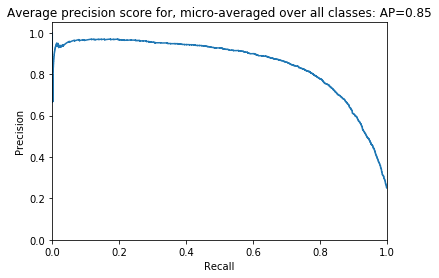

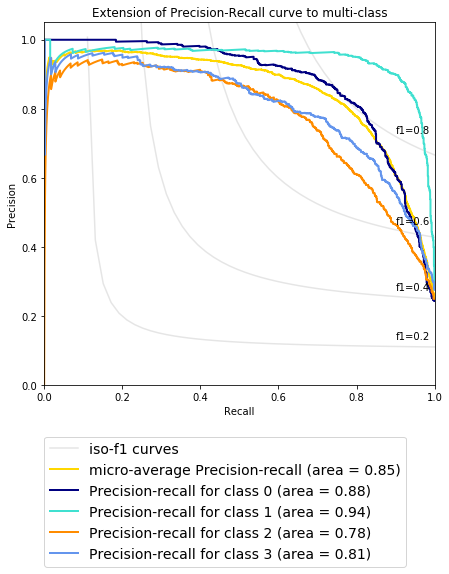

In [31]:
run_svm(x_train_bagofwords, y_train, x_test_bagofwords, 'Bag of Words')


 ### SVM for Bag of N-grams

Bag of N-Grams
Average precision score, micro-averaged over all classes: 0.72


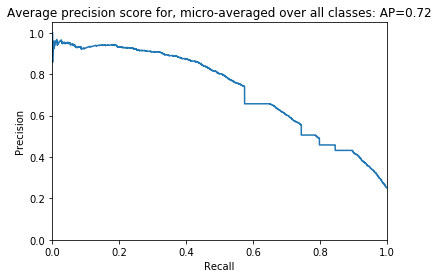

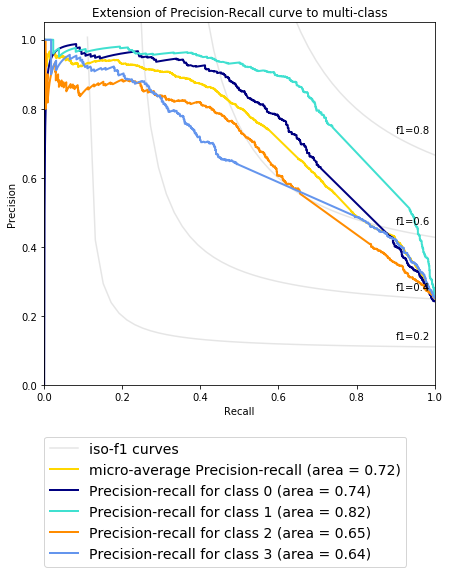

In [32]:
run_svm(x_train_bagofngrams, y_train, x_test_bagofngrams, 'Bag of N-Grams')


 ### SVM for Bag of Chars

Bag of Chars
Average precision score, micro-averaged over all classes: 0.80


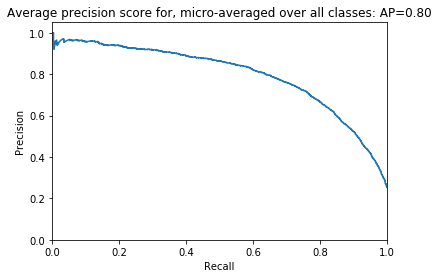

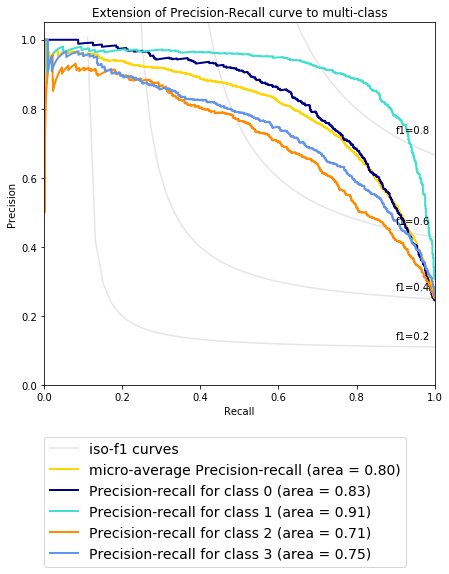

In [33]:
run_svm(x_train_cv_char, y_train, x_test_cv_char, 'Bag of Chars')


 ### SVM for TF/IDF Unigram

TF/IDF Unigram
Average precision score, micro-averaged over all classes: 0.89


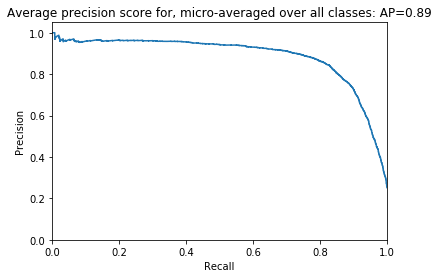

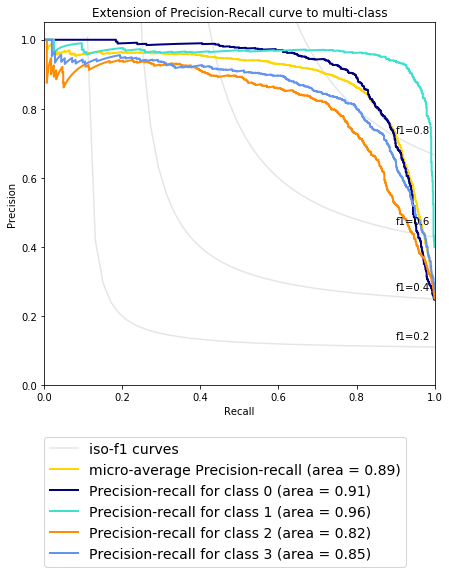

In [34]:
run_svm(x_train_tfidf_unigram, y_train, x_test_tfidf_unigram, 'TF/IDF Unigram')


 ### SVM for TF/IDF N-grams

TF/IDF N-Grams
Average precision score, micro-averaged over all classes: 0.76


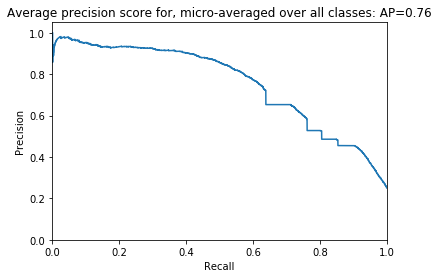

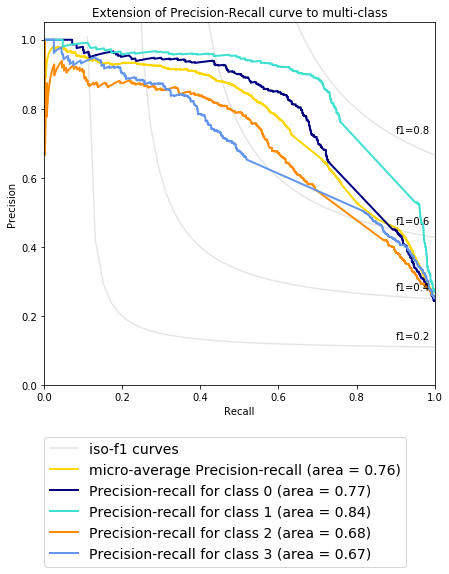

In [35]:
run_svm(x_train_tfidf_ngram, y_train, x_test_tfidf_ngram, 'TF/IDF N-Grams')


 ### SVM for TF/IDF Chars

TF/IDF Chars
Average precision score, micro-averaged over all classes: 0.80


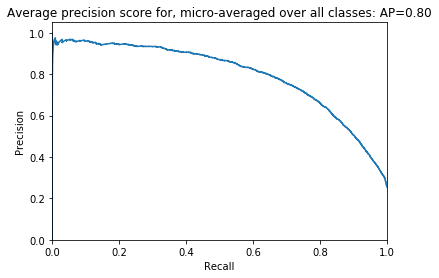

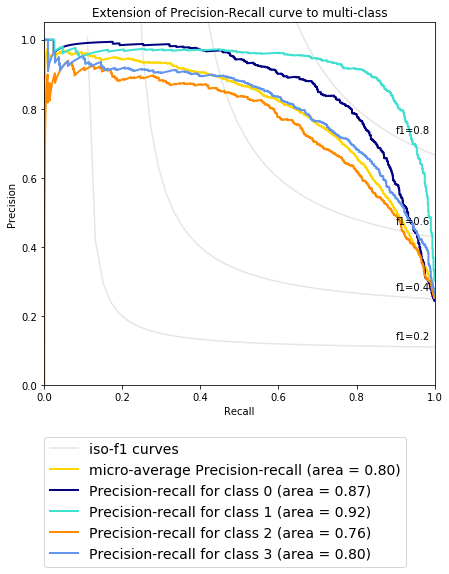

In [36]:
run_svm(x_train_tfidf_char, y_train, x_test_cv_char, 'TF/IDF Chars')


 ### SVM for Word2Vec

Word2Vec
Average precision score, micro-averaged over all classes: 0.71


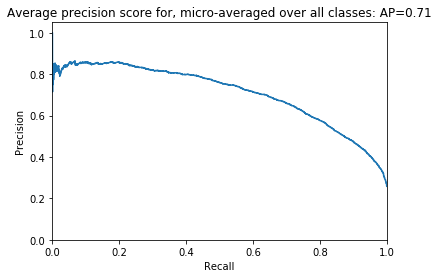

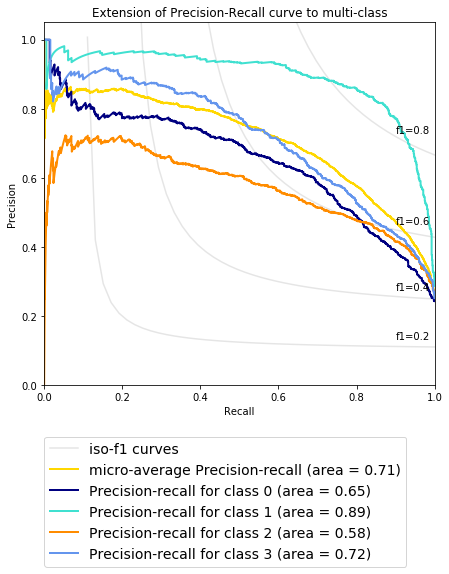

In [37]:
run_svm(x_train_w2v, y_train, x_test_w2v, 'Word2Vec')


 ## Let's explore also the SVM performance on 90th percentile feature selection

 ### SVM for Bag of Words 90th percentile

Bag of Words - 90th percentile
Average precision score, micro-averaged over all classes: 0.86


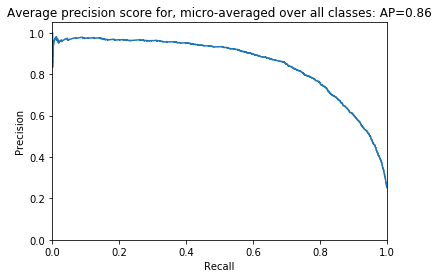

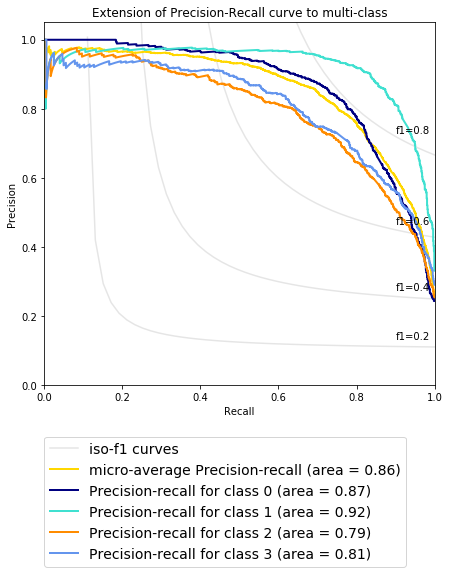

In [38]:
run_svm(x_train_bagofwords_10p, y_train, x_test_bagofwords_10p, 'Bag of Words - 90th percentile')


 ### SVM for Bag of N-grams 90th percentile

Bag of N-Grams - 90th percentile
Average precision score, micro-averaged over all classes: 0.66


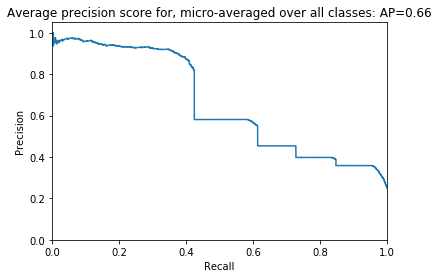

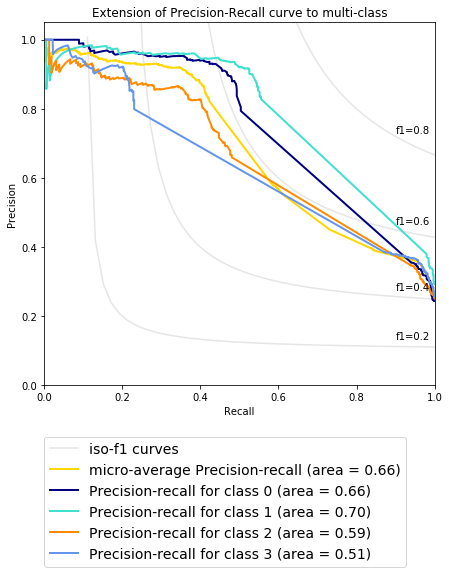

In [39]:
run_svm(x_train_bagofngrams_10p, y_train, x_test_bagofngrams_10p, 'Bag of N-Grams - 90th percentile')


 ### SVM for Bag of Chars 90th percentile

Bag of Chars - 90th percentile
Average precision score, micro-averaged over all classes: 0.81


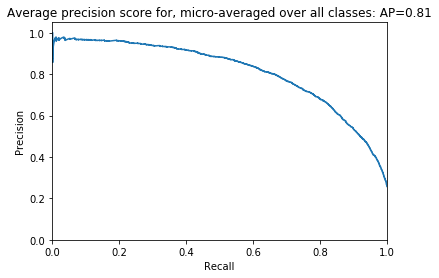

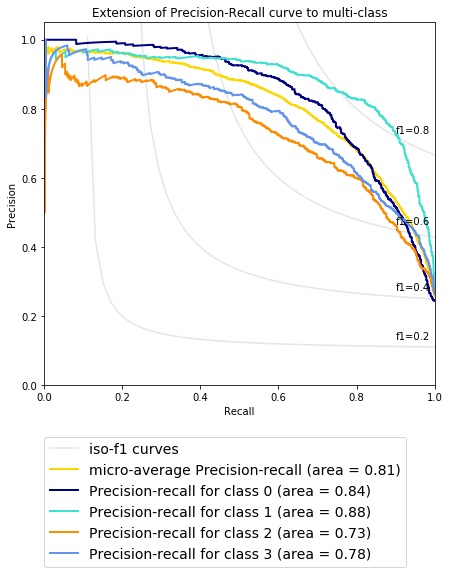

In [40]:
run_svm(x_train_cv_char_10p, y_train, x_test_cv_char_10p, 'Bag of Chars - 90th percentile')


# References - Code sample sources disclaimer:
Code for this project is either directly from (with some modification), or inspired by, but not limited to the following sources:
- Kelly Epley Naive Bayes: 
    https://towardsdatascience.com/naive-bayes-document-classification-in-python-e33ff50f937e
- MLWhiz's excellent blogs about text classification and NLP: 
    https://mlwhiz.com/blog/2018/12/17/text_classification/
    https://mlwhiz.com/blog/2019/01/17/deeplearning_nlp_preprocess/
    https://mlwhiz.com/blog/2019/02/08/deeplearning_nlp_conventional_methods/
    https://www.kaggle.com/mlwhiz/conventional-methods-for-quora-classification/
- Christof Henkel preprocessing: 
    https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings
- datanizing GmbH:
    https://medium.com/@datanizing/modern-text-mining-with-python-part-1-of-5-introduction-cleaning-and-linguistics-647f9ec85b6a
- Datacamp wordcloud:
    https://www.datacamp.com/community/tutorials/wordcloud-python
- Seaborn Pydata tutorials:
    https://seaborn.pydata.org/introduction.html#intro-plot-customization
- Dipanjan S's tutorials:
    https://github.com/dipanjanS
- Analytics Vidhya:
    https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/
- Jason Brownlee's Feature Selection For Machine Learning in Python
    https://machinelearningmastery.com/feature-selection-machine-learning-python/
- Susan Li's Multi-class text classification with Scikit-learn:
    https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f
- Vadim Smolyakov Ensemble Learning to Improve Machine Learning Results:
    https://blog.statsbot.co/ensemble-learning-d1dcd548e936
- Udacity course video on Youtube UD120:
    https://www.youtube.com/watch?v=GdsLRKjjKLw